In [7]:
import requests
import json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('darkgrid')

# Analysis

In [9]:
# df = pd.DataFrame(table)

In [4]:
df = pd.read_csv("data/publications.csv")

### Year

In [10]:
df = df.drop_duplicates("doi")

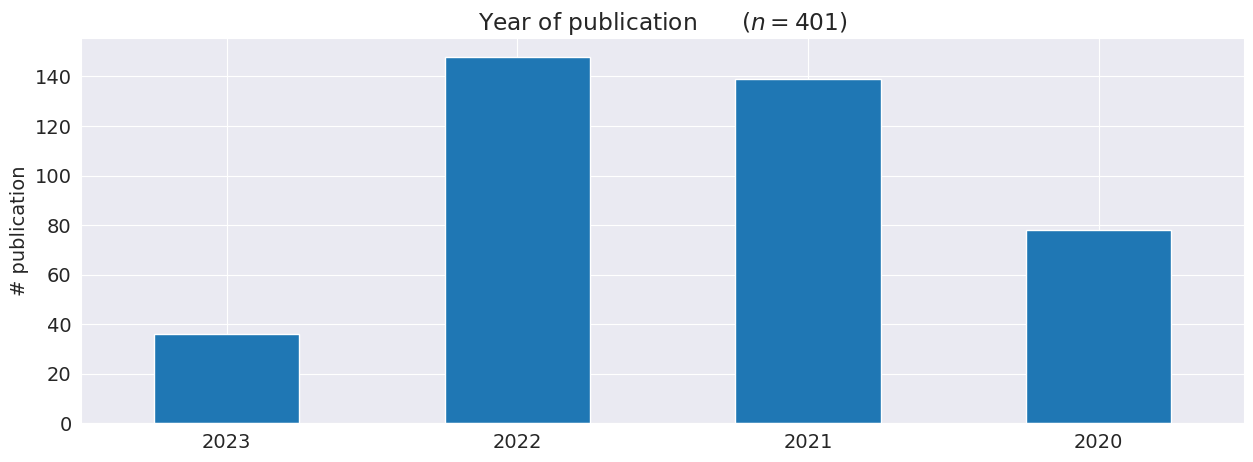

In [11]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(15, 5))
ax = df["year"].value_counts().sort_index(ascending=False).plot(kind="bar")
n = df["year"].count()
ax.set_ylabel("# publication")
ax.set_xlabel("")
ax.set_title(f"Year of publication \t ($n={n}$)")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

In [12]:
df["year"].value_counts()

2022    148
2021    139
2020     78
2023     36
Name: year, dtype: int64

### Conference

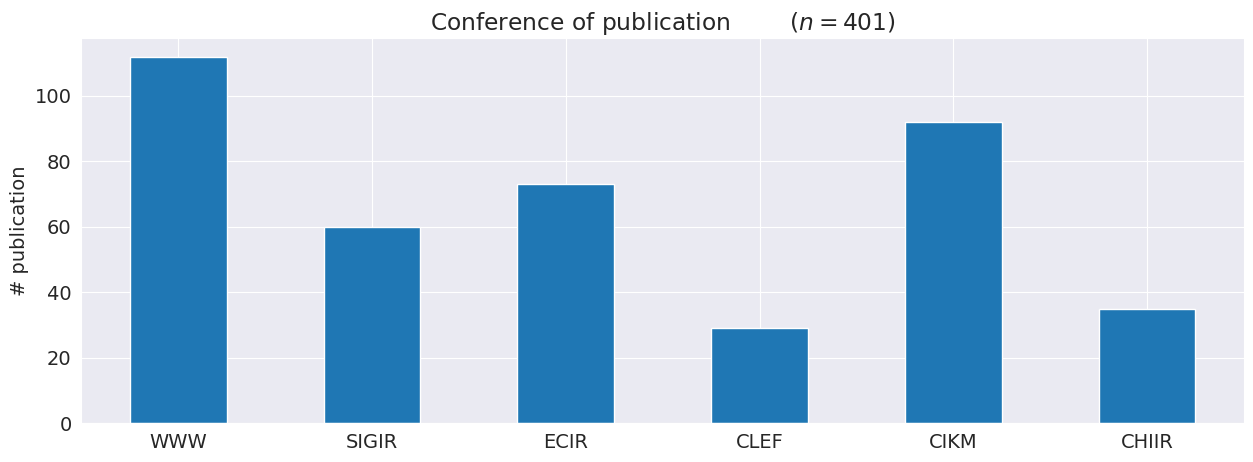

In [13]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(15, 5))
ax = df["acronym"].value_counts().sort_index(ascending=False).plot(kind="bar")
n = df["acronym"].count()
ax.set_ylabel("# publication")
ax.set_xlabel("")
ax.set_title(f"Conference of publication \t ($n={n}$)") 
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

### Authors

In [14]:
df["num_authors"].describe()

count    401.000000
mean       4.985037
std        4.191035
min        1.000000
25%        3.000000
50%        4.000000
75%        6.000000
max       36.000000
Name: num_authors, dtype: float64

/tmp/ipykernel_13997/427700068.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


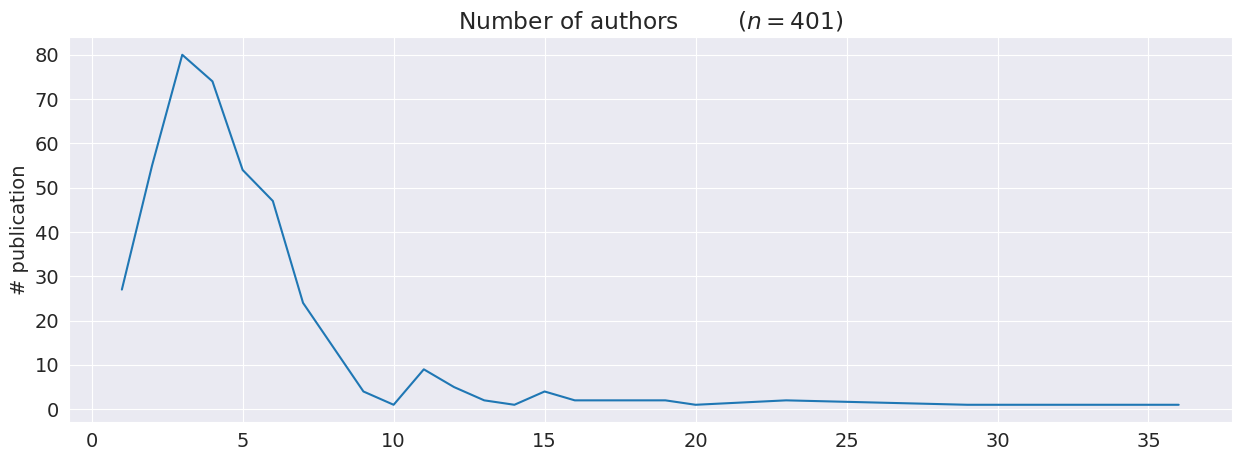

In [25]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(15, 5))
ax = df["num_authors"].value_counts().sort_index().plot(kind="line")
n = df["num_authors"].count()
ax.set_ylabel("# publication")
ax.set_xlabel("")
ax.set_title(f"Number of authors \t ($n={n}$)") 
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

### Top Tf-IDF topics

In [33]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, PorterStemmer
from nltk.corpus import stopwords
import nltk

In [34]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jueri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [38]:
df["title_clean"] = df["title"].apply(remove_punctuation)

/tmp/ipykernel_13997/4000913407.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["title_clean"] = df["title"].apply(remove_punctuation)


In [40]:
docs = df.groupby("acronym").agg({"title_clean": " ".join})

In [41]:
stemmer = SnowballStemmer('english')
# Initialize Porter stemmer
stemmer = PorterStemmer()

def custom_tokenizer(text):
    words = word_tokenize(text)

    # Stem words
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # Remove stopwords
    filtered_words = [word for word in stemmed_words if word not in stopwords.words('english')]
    
    # Create bi-grams
    bi_grams = [' '.join(bi) for bi in zip(filtered_words, filtered_words[1:])]
    
    return filtered_words + bi_grams

In [42]:
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)

In [43]:
tfidf_matrix = vectorizer.fit_transform(docs["title_clean"].tolist())

/home/jueri/miniconda3/envs/geo/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [44]:
vectorizer.get_feature_names_out()

array(['10th', '10th intern', '11th', ..., 'xvision explain', 'year',
       'year insid'], dtype=object)

In [45]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [46]:
docs.reset_index(inplace=True)

In [47]:
docs = pd.concat([docs, tfidf_df], axis=1)

In [48]:
docs.set_index("acronym", inplace=True)

In [49]:
docs = docs.drop("title_clean", axis=1)

In [53]:
top_100 = {}
for c in docs.T.columns:
    top = docs.T[c].sort_values(ascending=False)[:100].index.tolist()
    top = [x for x in top if not x.isnumeric()]
    top_100[c] = top[:20]

In [55]:
pd.DataFrame(top_100)

,CHIIR,CIKM,CLEF,ECIR,SIGIR,WWW
0,search,graph,overview,retriev,retriev,graph
1,user,knowledg graph,lab,bir,answer,knowledg
2,influenc,knowledg,retriev,overview,convers question,knowledg graph
3,strategi,learn,detect,detect,learn,use
4,engin,data,retriev overview,lab,question answer,network
5,search engin,semant,fake,inform,convers,data
6,interact,use,verif,evalu,question,link
7,privaci,network,authorship verif,rank,web,social
8,inform,machin,authorship,fake,answer heterogen,web
9,learn,link,fake news,style,sourc,learn
